# Basic Setup

Set up Basic Parameter here

In [67]:
import numpy as np
import random
from mv_laplace import MvLaplaceSampler
import matplotlib.pyplot as plt
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [68]:
# Define sample size
N = 10000 # number of subjects
N_T = 5000 # number of treated subjects

# Define betas
beta_11 = 2
beta_12 = 2
beta_21 = 2
beta_22 = 2
beta_23 = 2
beta_31 = 2

#Mask rate - (30%-50%)
lambda1 = 100
lambda2 = 25
lambda3 = 12


# Simulate X
The observed covariates for the $n$-th subject $(X_{n1}, X_{n2}, X_{n3}, X_{n4}, X_{n5})$ are i.i.d. generated through the following process: 


$    (X_{n1}, X_{n2})\sim \mathcal{N}\left[\left(\begin{array}{c}
\frac{1}{2}\\
-\frac{1}{3}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{2} \\
\frac{1}{2} & 1 
\end{array}\right)\right], (X_{n3}, X_{n4})\sim \text{Laplace}\left[\left(\begin{array}{c}
0\\
\frac{1}{\sqrt{3}}
\end{array}\right),\left(\begin{array}{cc}
1 & \frac{1}{\sqrt{2}} \\
\frac{1}{\sqrt{2}} & 1 
\end{array}\right)\right],
$
$X_{n5} \sim \text{Bernoulli}(1/3)$, for $n=1,\dots, N$



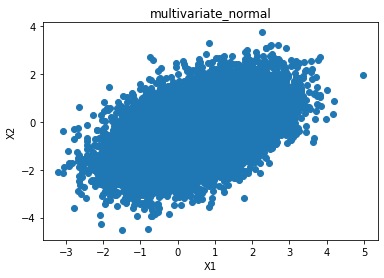

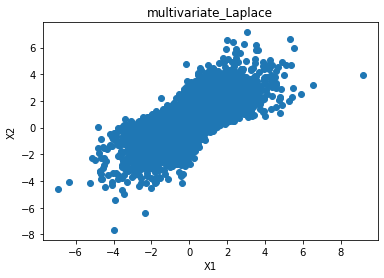

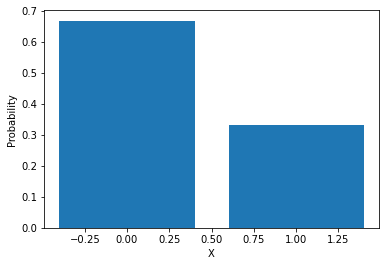

[[ 2.29569306  0.43973321  0.60818858  0.81905882  0.        ]
 [ 0.08646031  1.13693785  2.77817023  1.53024185  0.        ]
 [ 1.05032615  0.24758182  3.05842677  2.3027824   0.        ]
 ...
 [ 0.74410935 -2.30857307  0.16048325  0.93730245  1.        ]
 [ 0.44662052 -1.31553569 -0.01373099  0.96432266  1.        ]
 [-1.86473029 -1.20481377  1.45628127  0.86671573  0.        ]]


In [69]:
# generate Xn1 and Xn2
mean = [1/2, -1/3]
cov = [[1, 1/2], [1/2, 1]]
X1_2 = np.random.multivariate_normal(mean, cov, N)
plt.scatter(X1_2[:, 0], X1_2[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_normal")
plt.show()

# generate Xn3 and Xn4
loc = [0, 1/np.sqrt(3)]
cov = [[1,1/np.sqrt(2)], [1/np.sqrt(2),1]]

sampler = MvLaplaceSampler(loc, cov)
X3_4 = sampler.sample(N)
plt.scatter(X3_4[:, 0], X3_4[:, 1])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title("multivariate_Laplace")
plt.show()

# generate Xn5
p = 1/3
X5 = np.random.binomial(1, p, N)

counts = np.unique(X5, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('X')
plt.ylabel('Probability')
plt.show()

# combine all generated variables into a single matrix
X = np.hstack((X1_2, X3_4, X5.reshape(-1,1)))

print(X)

# Simulate U

The unobserved covariates for the $n$-th subject $(U_{n1}, U_{n2})$ are i.i.d. generated through the following process: $U_{n1}\sim N(1/2, 1)$ and $U_{n2}\sim \text{Bernoulli}(2/3)$, for $n=1,\dots, N$.

In [70]:
# generate Un1
mean = 1/2
std = 1
U_n1 = np.random.normal(mean, std, N)

# generate Un2
U_n2 = np.random.binomial(1, 2/3, N)

U = np.concatenate((U_n1.reshape(-1, 1), U_n2.reshape(-1, 1)), axis=1)

U


array([[ 0.74192759,  1.        ],
       [ 0.00689709,  1.        ],
       [-0.67673989,  1.        ],
       ...,
       [ 0.47463429,  1.        ],
       [ 0.88692239,  1.        ],
       [ 1.78994383,  0.        ]])

# Simulate Z
The observed treatment indicators $\mathbf{Z}=(Z_{1}, \dots, Z_{N})\in \{0, 1\}^{N}$ follow a completely randomized experiment: $P(\mathbf{Z}=\mathbf{z})={N\choose N_{T}}^{-1}$ for any $\mathbf{z}=(z_{1},\dots, z_{N})\in \{0,1\}^{N}$ with $\sum_{n=1}^{N}z_{n}=N_{T}$.

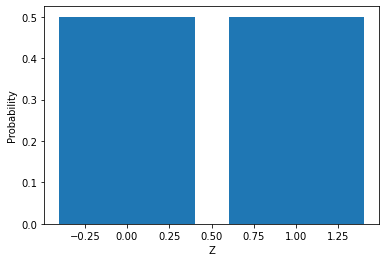

array([0., 0., 0., ..., 0., 1., 1.])

In [71]:
Z = np.zeros(N)
Z[:N_T] = 1
np.random.shuffle(Z)

counts = np.unique(Z, return_counts=True)
plt.bar(counts[0], counts[1]/N)
plt.xlabel('Z')
plt.ylabel('Probability')
plt.show()
Z = Z.reshape(-1,)
Z

# Simulate Y

The three outcomes of interest $(Y_{n1}, Y_{n2}, Y_{n3})$ are generated via the following process (for $n=1,\dots, N$):

\begin{align*}
    
    &Y_{n1}= \beta_{11} Z_{n}+\beta_{12}Z_{n}\cdot \sum_{p=1}^{5}\sqrt{p}\cdot \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin(U_{n1})+U_{n2},\\
    &Y_{n2}= \beta_{21} Z_{n} + \beta_{22}Z_{n} X_{n1}+ \beta_{23}Z_{n} U_{n1}U_{n2}+\sum_{p=1}^{5}(\cos{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}\cdot \exp(X_{np^{\prime}}),  \\
    &Y_{n3}= \beta_{31} Z_{n} + \sum_{p=1}^{5}(\sin{p})\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}\exp(X_{np^{\prime\prime}})+X_{n1} X_{n2}\cdot \sin (U_{n1}U_{n2}).
   
\end{align*}
    

In [72]:
#def sum1():
sum1 = np.zeros(N)
for p in range(1,6):
  sum1 += np.sqrt(p) * np.exp(X[:,p-1])

#def sum2():
sum2 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum2 += X[:,p-1] * np.power(X[:,p_2-1],2)

#def sum3():
sum3 = np.zeros(N)

for p in range(1,6):
  sum3 += np.cos(p) * X[:,p-1]

#def sum4():
sum4 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    sum4 += X[:,p-1] * np.exp(X[:,p_2-1])

#def sum5():
sum5 = np.zeros(N)
for p in range(1,6):
  sum5 += np.sin(p) * X[:,p-1]

#def sum6(): 
sum6 = np.zeros(N)
for p in range(1,6):
  for p_2 in range(1,6):
    for p_3 in range(1,6):
      sum6 += X[:,p-1] * X[:,p_2-1] * np.exp(X[:,p_3-1])


# Calculate Y_n1
Y_n1 = (beta_11 * Z + beta_12 * Z * sum1   + sum2 + np.sin(U_n1) + U_n2) 

# Compute Yn2
Y_n2 = (beta_21 * Z + beta_22 * Z * X[:,0] + beta_23 * Z * U_n1 * U_n2 + sum3 + sum4) 

# Compute Yn3
Y_n3 = (beta_31 * Z + sum5 + sum6 + X[:,0] * X[:,1] * np.sin(U_n1 * U_n2)) 

Y = np.concatenate((Y_n1.reshape(-1, 1), Y_n2.reshape(-1, 1),Y_n3.reshape(-1, 1)), axis=1) 
print(Y.shape)

(20000, 3)


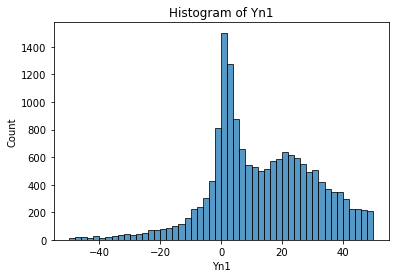

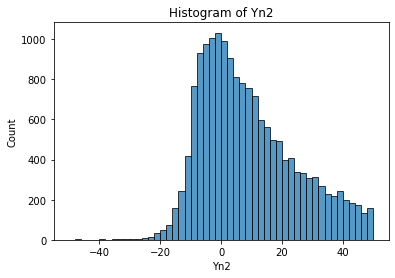

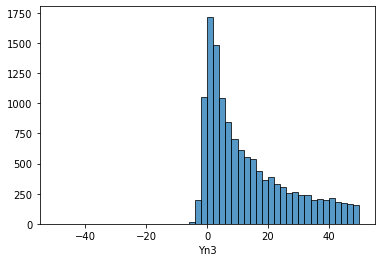

In [73]:
# Plot histogram of Yn1
plt.hist(Y_n1, bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Yn2
plt.hist(Y_n2, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Yn3
plt.hist(Y_n3, bins=50,range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Yn3')
plt.show()

#Simulate M

\begin{align*}
            &M_{n1}=\mathbf{1}\Big \{\sum_{p=1}^{5} \exp(X_{np})+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np} X_{np^{\prime}}^{2}+\sin^{3}(U_{n1})+U_{n2} + \exp(Y_{n1})> \lambda_{1} \} \\
            &M_{n2}=\mathbf{1}\Big \{\sum_{p=1}^{5} X_{np}^{3}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}X_{np}X_{np^{\prime}}+U_{n1}+ \frac{1}{2}\cdot Y_{n1}^{3}+Y_{n2}>\lambda_{2} \} \\
            &  M_{n3}=\mathbf{1}\Big \{\sum_{p=1}^{5}p\cdot X_{np}+\sum_{p=1}^{5}\sum_{p^{\prime}=1}^{5}\sum_{p^{\prime\prime}=1}^{5}X_{np} X_{np^{\prime}}X_{np^{\prime\prime}}+\sin(U_{n1})\cdot U_{n2} + Y_{n1} + \exp(Y_{n2}) > \lambda_{3} \}. 
\end{align*}






In [74]:

def missing_dataset_indicator(X, U, Y, lambda1, lambda2, lambda3, single = True):
    n = X.shape[0]
    M = np.zeros((n, 3))
    M_lamda = np.zeros((n, 3))

    for i in range(n):
        sum1 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum1 += X[i,p-1] * np.power(X[i,p_2-1],2)
          
        sum2 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            sum2 += X[i,p-1] * X[i,p_2-1]

        sum3 = 0
        for p in range(1,6):
            sum3 += p * X[i,p-1] 

        sum4 = 0
        for p in range(1,6):
          for p_2 in range(1,6):
            for p_3 in range(1,6):
              sum4 += X[i,p-1] * X[i,p_2-1] * X[i,p_3-1]

        M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])

        M_lamda[i][1] = ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1])

        M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))

        if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:
          M[i][0] = 1 - single
        else:
          M[i][0] = 0
        
        if ((X[i, :]**3).sum() + sum2 + U[i, 0] + (Y[i, 0]**3)/2 + Y[i, 1]) > lambda2:
          M[i][1] =  1 - single
        else:
          M[i][1] =  0

        if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
          M[i][2] =  0
        else:
          M[i][2] =  1

    return M,M_lamda
M,M_lamda = missing_dataset_indicator(X,U,Y,lambda1,lambda2,lambda3)
display(pd.DataFrame(M))
print(M_lamda)


/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:31: RuntimeWarning: overflow encountered in exp
  M_lamda[i][2] = (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1]))
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:43: RuntimeWarning: overflow encountered in exp
  if (sum3 + sum4 + np.sin(U[i, 0]) * U[i, 1] + Y[i, 0] + np.exp(Y[i, 1])) > lambda3:
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:27: RuntimeWarning: overflow encountered in exp
  M_lamda[i][0] = np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])
/var/folders/gl/3msbrfh11bx8rfwqwpc91jm40000gn/T/ipykernel_59412/2862711778.py:33: RuntimeWarning: overflow encountered in exp
  if (np.exp(X[i, :]).sum() + sum1 + np.sin(U[i, 0])**3 + U[i, 1] + np.exp(Y[i, 0])) > lambda1:


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,0.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


[[3.06504293e+012 1.19831812e+004 9.02352121e+029]
 [5.35652023e+027 1.30337305e+005 2.80747115e+060]
 [8.27351038e+045 5.91282961e+005 4.02899447e+103]
 ...
 [2.87112707e+002 8.44742985e+001 2.53300246e+002]
 [2.88548433e+016 2.72379553e+004 1.14193052e+006]
 [6.24076068e+011 1.00045330e+004 3.03048454e+001]]


[3.06504293e+12 5.35652023e+27 8.27351038e+45 ... 2.87112707e+02
 2.88548433e+16 6.24076068e+11]
[3.06504293e+12 1.19831812e+04 9.02352121e+29]


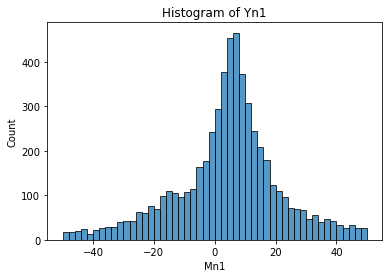

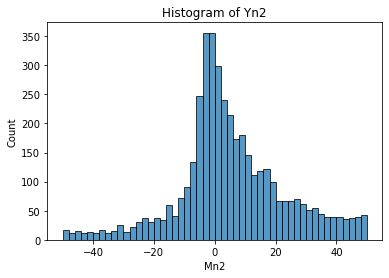

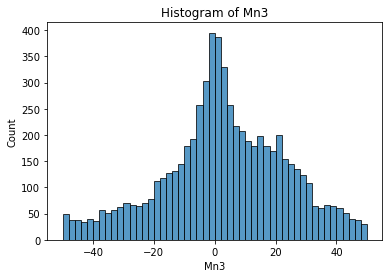

In [75]:
# Plot histogram of Mn1
print(M_lamda[:,0])
print(M_lamda[0,:])

plt.hist(M_lamda[:,0], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn1')
plt.ylabel('Count')
plt.title('Histogram of Yn1')
plt.show()

# Plot histogram of Mn2
plt.hist(M_lamda[:,1], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn2')
plt.ylabel('Count')
plt.title('Histogram of Yn2')
plt.show()

# Plot histogram of Mn3
plt.hist(M_lamda[:,2], bins=50, range = (-50,50), edgecolor='black', alpha=0.75)
plt.xlabel('Mn3')
plt.ylabel('Count')
plt.title('Histogram of Mn3')
plt.show()

In [76]:
print(M[:,0].sum() / N)

print(M[:,1].sum() / N)

print(M[:,2].sum() / N)

0.0
0.0
0.2674


# Matching

In [ ]:


# Load the treatment dataset and the control dataset
treatment_df = pd.read_csv('treatment_data.csv')
control_df = pd.read_csv('control_data.csv')

# Choose the variable X to match on
x_var = 'x_variable_name'

# Fit a nearest neighbor model to the control dataset based on X
nn_model = NearestNeighbors(n_neighbors=1)
nn_model.fit(control_df[x_var].values.reshape(-1,1))

# For each treatment observation, find the closest control observation based on X
distances, indices = nn_model.kneighbors(treatment_df[x_var].values.reshape(-1,1), n_neighbors=1)
matched_control_df = control_df.iloc[indices.flatten()]

# Add a column to the matched control dataset indicating the stratum assignment
num_strata = 100
matched_control_df['stratum'] = np.random.randint(1, num_strata+1, size=len(matched_control_df))

# Merge the matched control dataset with the treatment dataset
matched_df = pd.concat([treatment_df, matched_control_df], axis=1)

# Remove the original indices from the matched dataframe
matched_df.reset_index(drop=True, inplace=True)

# Split the matched dataset into 100 strata
strata_dfs = [matched_df[matched_df['stratum']==i] for i in range(1, num_strata+1)]


# Save all the simulated data


In [77]:
# Read the data,it is important to put the "Research" directory in ones own google drive
Z = Z.reshape((-1,1))

np.save("/Users/jiaweizhang/research/data/X.npy", X)
np.save("/Users/jiaweizhang/research/data/Y.npy", Y)
np.save("/Users/jiaweizhang/research/data/Z.npy", Z)
np.save("/Users/jiaweizhang/research/data/U.npy", U)
np.save("/Users/jiaweizhang/research/data/M.npy", M)

print(X.shape)
display(pd.DataFrame(X))
print(pd.DataFrame(X).describe())
print(Y.shape)
display(pd.DataFrame(Y))
print(pd.DataFrame(Y).describe())
print(Z.shape)
display(pd.DataFrame(Z))
print(pd.DataFrame(Z).describe())
print(U.shape)
display(pd.DataFrame(U))
print(pd.DataFrame(U).describe())
print(M.shape)
display(pd.DataFrame(M))
print(pd.DataFrame(M).describe())


print("Sucessfully Saved")

(20000, 5)


,0,1,2,3,4
0,2.295693,0.439733,0.608189,0.819059,0.0
1,0.086460,1.136938,2.778170,1.530242,0.0
2,1.050326,0.247582,3.058427,2.302782,0.0
3,1.474758,-0.743932,0.626448,0.607590,1.0
4,1.864659,0.259214,4.016073,3.808354,0.0
...,...,...,...,...,...
19995,0.525600,-1.660931,1.505078,0.582183,0.0
19996,0.219933,-0.140858,0.283544,1.203173,0.0
19997,0.744109,-2.308573,0.160483,0.937302,1.0
19998,0.446621,-1.315536,-0.013731,0.964323,1.0


                  0             1             2             3             4
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000
mean       0.492005     -0.346586     -0.003275      0.575764      0.332700
std        0.996114      1.002453      1.005627      1.005136      0.471192
min       -3.208076     -4.516988     -6.925419     -7.658484      0.000000
25%       -0.178373     -1.025420     -0.498800      0.081291      0.000000
50%        0.492449     -0.340123     -0.001535      0.578917      0.000000
75%        1.161444      0.323492      0.480324      1.070851      1.000000
max        4.960384      3.752681      9.160558      7.145386      1.000000
(20000, 3)


,0,1,2
0,28.751083,68.974802,289.932718
1,63.848112,139.187390,793.405915
2,105.729388,238.559781,1615.325461
3,14.032268,33.788091,98.613112
4,340.594291,1081.869565,10817.425118
...,...,...,...
19995,39.898267,11.657217,8.692235
19996,3.303459,11.281356,18.249855
19997,5.610258,5.487795,-1.443561
19998,37.901054,13.948190,8.579751


                  0              1             2
count  20000.000000   20000.000000  2.000000e+04
mean      30.238011      41.531361  3.060523e+02
std      259.893209     949.423460  1.290202e+04
min     -937.711943     -60.471025 -5.565756e+00
25%        2.257134      -1.427946  4.957111e+00
50%       17.141191      10.024079  2.224157e+01
75%       35.956660      32.315870  8.906838e+01
max    34567.862386  131258.245898  1.800465e+06
(20000, 1)


,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
19995,1.0
19996,0.0
19997,0.0
19998,1.0


                  0
count  20000.000000
mean       0.500000
std        0.500013
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
(20000, 2)


,0,1
0,0.741928,1.0
1,0.006897,1.0
2,-0.676740,1.0
3,-0.283600,1.0
4,-0.416185,1.0
...,...,...
19995,0.383300,1.0
19996,-0.197186,1.0
19997,0.474634,1.0
19998,0.886922,1.0


                  0             1
count  20000.000000  20000.000000
mean       0.498824      0.660950
std        0.993884      0.473399
min       -3.777854      0.000000
25%       -0.172227      0.000000
50%        0.495311      1.000000
75%        1.167500      1.000000
max        4.457030      1.000000
(20000, 3)


,0,1,2
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
...,...,...,...
19995,0.0,0.0,0.0
19996,0.0,0.0,0.0
19997,0.0,0.0,0.0
19998,0.0,0.0,0.0


             0        1             2
count  20000.0  20000.0  20000.000000
mean       0.0      0.0      0.267400
std        0.0      0.0      0.442614
min        0.0      0.0      0.000000
25%        0.0      0.0      0.000000
50%        0.0      0.0      0.000000
75%        0.0      0.0      1.000000
max        0.0      0.0      1.000000
Sucessfully Saved
